In [1]:
import numpy as np
import pandas as pd

In [22]:
train_df_umap = pd.read_csv("C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/1.MinMaxScaled_UMAP_OPTICS_v1/MinMaxScaled_UMAP_OPTICS_v1.csv", index_col=0)
del train_df_umap['OPTICS_cluster_without_noise']
train_df_umap.head(5)

,UMAP1,UMAP2
지번주소,,
서울특별시 광진구 광장동 102,9.582932,20.618004
서울특별시 광진구 광장동 104,9.550850,20.616909
서울특별시 광진구 광장동 105,9.613869,20.606441
서울특별시 광진구 광장동 106,9.591617,20.614060
서울특별시 광진구 광장동 107,9.587208,20.618753


## optics 파라미터 튜닝

In [4]:
def silhouette(clustering_result) : 
    from sklearn.metrics import silhouette_score

    # 클러스터링 결과에서 노이즈 포인트 제외한 데이터와 클러스터 레이블 추출
    X = clustering_result[['UMAP1', 'UMAP2']]
    labels = clustering_result['OPTICS_cluster_without_noise']

    # 실루엣 점수 계산
    silhouette_avg = silhouette_score(X, labels)

    return silhouette_avg

In [5]:
# 노이즈 포인트를 제외한 클러스터링 결과
def get_without_noise_optics(train_df_umap) :
    from sklearn.cluster import OPTICS

    min_samples = range(10, 101, 10)
    xi = np.arange(0, 0.06, 0.01)
    metric = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
    result=[] # 결과 저장

    for a in min_samples :
        for b in xi : 
            for c in metric : 
                # OPTICS 객체 생성 및 매개 변수 설정
                optics_clustering = OPTICS(
                    min_samples=a,  # 샘플 개수 조정 (값이 클수록 밀도 증가)
                    xi=b,  # xi 값을 조정 (값이 클수록 더 많은 클러스터 계층이 생성)
                    #min_cluster_size=10,  # 클러스터 최소 크기 조정 -> 이 값보다 작은 클러스터는 노이즈로 간주 (값이 작을수록 군집 수 증가)
                    metric=c  # 거리 척도 변경
                )

                # cluster_all 매개 변수 설정 (노이즈 제거)
                optics_clustering.cluster_all = False

                # UMAP으로 축소된 데이터(train_df_umap)에 OPTICS 적용
                optics_clustering.fit(train_df_umap)

                # 클러스터링 결과를 train_df_umap DataFrame에 추가
                train_df_umap['OPTICS_cluster_without_noise'] = optics_clustering.labels_
                train_df_umap = train_df_umap[train_df_umap['OPTICS_cluster_without_noise'] != -1]  # 노이즈 포인트 제거

                # 실루엣 점수가 0.65 초과인 것만 저장
                silhouette_avg = silhouette(train_df_umap)
                if silhouette_avg > 0.65 :
                    result.append(f"silhouette_avg: {silhouette_avg}, min_samples: {a}, xi: {b}, metric: {c}")
    
    return result

best_parms = get_without_noise_optics(train_df_umap)
best_parms

C:\Users\dohee\AppData\Local\Temp\ipykernel_14840\1535666570.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_umap['OPTICS_cluster_without_noise'] = optics_clustering.labels_


['silhouette_avg: 0.7344210486656184, min_samples: 10, xi: 0.0, metric: cityblock',
 'silhouette_avg: 0.7183524278152075, min_samples: 10, xi: 0.0, metric: cosine',
 'silhouette_avg: 0.7456584315571428, min_samples: 10, xi: 0.0, metric: euclidean',
 'silhouette_avg: 0.7478245350703253, min_samples: 10, xi: 0.0, metric: l1',
 'silhouette_avg: 0.7479150796186435, min_samples: 10, xi: 0.0, metric: l2',
 'silhouette_avg: 0.7479150796186435, min_samples: 10, xi: 0.0, metric: manhattan',
 'silhouette_avg: 0.7479150796186435, min_samples: 10, xi: 0.01, metric: cityblock',
 'silhouette_avg: 0.7482611089210236, min_samples: 10, xi: 0.01, metric: cosine',
 'silhouette_avg: 0.7673883162266085, min_samples: 10, xi: 0.01, metric: euclidean',
 'silhouette_avg: 0.767413645064948, min_samples: 10, xi: 0.01, metric: l1',
 'silhouette_avg: 0.767413645064948, min_samples: 10, xi: 0.01, metric: l2',
 'silhouette_avg: 0.767413645064948, min_samples: 10, xi: 0.01, metric: manhattan',
 'silhouette_avg: 0.767

In [10]:
best_param = max(best_parms, key=lambda x: x.split(",")[0].split(":")[1])
print("Best params: " + best_param)

Best params: silhouette_avg: 0.7976492854187452, min_samples: 20, xi: 0.05, metric: euclidean


In [34]:
# best_param 데이터프레임으로 변환
df = pd.DataFrame({'params': best_parms})

df[['silhouette_avg', 'min_samples', 'xi', 'metric']] = df['params'].str.extract(r'silhouette_avg: ([\d\.]+), min_samples: (\d+), xi: ([\d\.]+), metric: (\w+)')
df.drop('params', axis=1, inplace=True)
df = df.astype({'silhouette_avg': 'float64', 'min_samples': 'int64', 'xi': 'float64'})
df

,silhouette_avg,min_samples,xi,metric
0,0.734421,10,0.00,cityblock
1,0.718352,10,0.00,cosine
2,0.745658,10,0.00,euclidean
3,0.747825,10,0.00,l1
4,0.747915,10,0.00,l2
...,...,...,...,...
349,0.658502,100,0.05,cosine
350,0.759905,100,0.05,euclidean
351,0.759905,100,0.05,l1
352,0.759905,100,0.05,l2


In [35]:
df.to_excel('C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/4.Clustering_Tuning/OPTICS_best_params.xlsx', index=False)

## best 파라미터로 클러스터링 결과 확인

In [23]:
# 노이즈 포인트를 제외한 클러스터링 결과
def get_without_noise_optics(train_df_umap) :
    from sklearn.cluster import OPTICS

    # OPTICS 객체 생성 및 매개 변수 설정 (min_samples, xi, min_cluster_size 등)
    optics_clustering = OPTICS(
        min_samples=20, 
        xi=0.05, 
        metric='euclidean'
    )

    # cluster_all 매개 변수 설정
    optics_clustering.cluster_all = False

    # UMAP으로 축소된 데이터(train_df_umap)에 OPTICS 적용
    optics_clustering.fit(train_df_umap)

    # 모델 저장
    import pickle

    with open("C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/4.Clustering_Tuning/MinMaxScaled_UMAP_OPTICS_v2.pkl", "wb") as file:
        pickle.dump(optics_clustering, file)

    # 클러스터링 결과를 train_df_umap DataFrame에 추가
    train_df_umap['OPTICS_cluster_without_noise'] = optics_clustering.labels_
    train_df_umap = train_df_umap[train_df_umap['OPTICS_cluster_without_noise'] != -1]  # 노이즈 포인트 제거
    
    return train_df_umap

get_without_noise_optics = get_without_noise_optics(train_df_umap)
get_without_noise_optics

,UMAP1,UMAP2,OPTICS_cluster_without_noise
지번주소,,,
서울특별시 광진구 광장동 102,9.582932,20.618004,0
서울특별시 광진구 광장동 104,9.550850,20.616909,0
서울특별시 광진구 광장동 105,9.613869,20.606441,0
서울특별시 광진구 광장동 106,9.591617,20.614060,0
서울특별시 광진구 광장동 107,9.587208,20.618753,0
...,...,...,...
서울특별시 광진구 화양동 94-9,10.578531,9.630198,202
서울특별시 광진구 화양동 95-1,10.241718,10.397037,200
서울특별시 광진구 화양동 95-5,10.225814,10.401922,200


In [27]:
get_without_noise_optics.to_csv('C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/4.Clustering_Tuning/MinMaxScaled_UMAP_OPTICS_v2.csv')

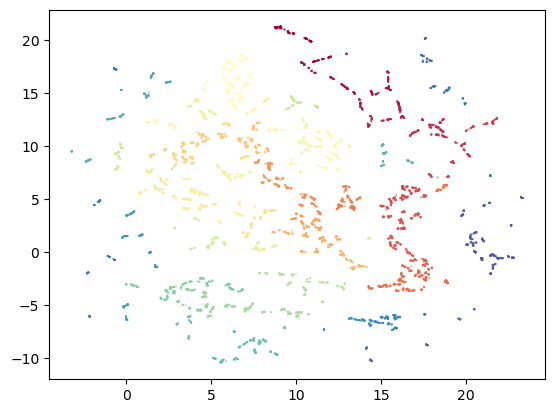

In [28]:
def visualization_data(clustering_result):
    import matplotlib.pyplot as plt

    # 노이즈 포인트 제외
    clustered = (clustering_result >= 0)
    plt.scatter(clustering_result['UMAP1'],
                clustering_result['UMAP2'],
                c=clustering_result['OPTICS_cluster_without_noise'],
                s=0.1,
                cmap='Spectral')
    plt.show()
    
get_without_noise_optics_v = visualization_data(get_without_noise_optics)
get_without_noise_optics_v

In [26]:
# 성능 평가

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import DistanceMetric

# Dunn 지수 계산 함수
def dunn(clustering_result):
    dist = DistanceMetric.get_metric('euclidean')
    labels = clustering_result['OPTICS_cluster_without_noise']
    clusters = np.unique(labels)
    centroids = [np.mean(clustering_result.loc[labels==i, ['UMAP1', 'UMAP2']], axis=0) for i in clusters]
    max_intracluster_distances = [np.max(dist.pairwise(clustering_result.loc[labels==i, ['UMAP1', 'UMAP2']])) for i in clusters]
    min_intercluster_distances = []
    for i, c1 in enumerate(centroids):
        for j, c2 in enumerate(centroids):
            if i < j:
                dist_ij = dist.pairwise([c1, c2])[0][1]
                min_intercluster_distances.append(dist_ij)
    return np.min(min_intercluster_distances) / np.max(max_intracluster_distances)

# Calinski-Harabasz 지수 계산 함수
def calinski_harabasz(clustering_result):
    labels = clustering_result['OPTICS_cluster_without_noise']
    return calinski_harabasz_score(clustering_result[['UMAP1', 'UMAP2']], labels)

# Dunn 지수와 Calinski-Harabasz 지수 계산
sil_score = silhouette(get_without_noise_optics)
dunn_score = dunn(get_without_noise_optics)
ch_score = calinski_harabasz(get_without_noise_optics)

# 출력
print(f"실루엣 score: {sil_score}")
print(f"Dunn score: {dunn_score:.4f}")
print(f"Calinski-Harabasz score: {ch_score:.4f}")

C:\Users\dohee\AppData\Roaming\Python\Python39\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


실루엣 score: 0.7395179619996689
Dunn score: 0.1289
Calinski-Harabasz score: 123077.4325


<hr>

## 재시도

In [42]:
train_df_umap = pd.read_csv("C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/1.MinMaxScaled_UMAP_OPTICS_v1/MinMaxScaled_UMAP_OPTICS_v1.csv", index_col=0)
del train_df_umap['OPTICS_cluster_without_noise']

In [43]:
# 노이즈 포인트를 제외한 클러스터링 결과
def get_without_noise_optics(train_df_umap) :
    from sklearn.cluster import OPTICS

    # OPTICS 객체 생성 및 매개 변수 설정 (min_samples, xi, min_cluster_size 등)
    optics_clustering = OPTICS(
        min_samples=10, 
        xi=0.05, 
        metric='euclidean'
    )

    # cluster_all 매개 변수 설정
    optics_clustering.cluster_all = False

    # UMAP으로 축소된 데이터(train_df_umap)에 OPTICS 적용
    optics_clustering.fit(train_df_umap)

    # 모델 저장
    import pickle

    with open("C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/4.Clustering_Tuning/MinMaxScaled_UMAP_OPTICS_v3.pkl", "wb") as file:
        pickle.dump(optics_clustering, file)

    # 클러스터링 결과를 train_df_umap DataFrame에 추가
    train_df_umap['OPTICS_cluster_without_noise'] = optics_clustering.labels_
    train_df_umap = train_df_umap[train_df_umap['OPTICS_cluster_without_noise'] != -1]  # 노이즈 포인트 제거
    
    return train_df_umap

get_without_noise_optics = get_without_noise_optics(train_df_umap)
get_without_noise_optics

,UMAP1,UMAP2,OPTICS_cluster_without_noise
지번주소,,,
서울특별시 광진구 광장동 102,9.582932,20.618004,0
서울특별시 광진구 광장동 104,9.550850,20.616909,0
서울특별시 광진구 광장동 105,9.613869,20.606441,0
서울특별시 광진구 광장동 106,9.591617,20.614060,0
서울특별시 광진구 광장동 107,9.587208,20.618753,0
...,...,...,...
서울특별시 광진구 화양동 94-9,10.578531,9.630198,444
서울특별시 광진구 화양동 95-1,10.241718,10.397037,441
서울특별시 광진구 화양동 95-5,10.225814,10.401922,441


In [44]:
# Dunn 지수와 Calinski-Harabasz 지수 계산
sil_score = silhouette(get_without_noise_optics)
dunn_score = dunn(get_without_noise_optics)
ch_score = calinski_harabasz(get_without_noise_optics)

# 출력
print(f"실루엣 score: {sil_score}")
print(f"Dunn score: {dunn_score:.4f}")
print(f"Calinski-Harabasz score: {ch_score:.4f}")

C:\Users\dohee\AppData\Roaming\Python\Python39\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


실루엣 score: 0.7551380205154365
Dunn score: 0.0157
Calinski-Harabasz score: 311302.7714


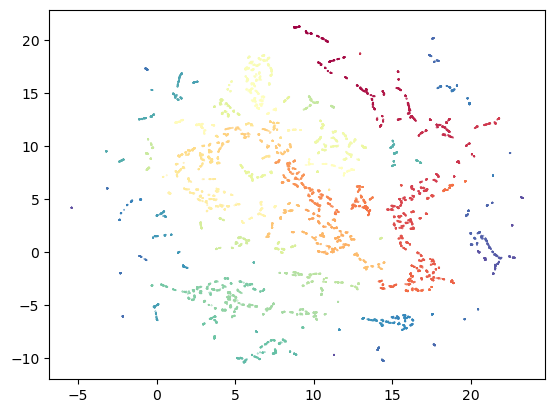

In [45]:
get_without_noise_optics_v = visualization_data(get_without_noise_optics)
get_without_noise_optics_v

In [46]:
get_without_noise_optics.to_csv('C:/Python_practice/DL_project/gwangjin_contest/EDA_and_Model/4.Clustering_Tuning/MinMaxScaled_UMAP_OPTICS_v3.csv')